In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helpers.helper_functions import *
import re
import warnings
warnings.filterwarnings('ignore')

# The Significant Bang Theory

Attention, ADA students!

The Sheldon Cooper we all know and love (OK, some of us don't know him, and some don't love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove.The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Deadline
Thursday, January 17th, 2018; 12:35 P.M. CEST

## Important notes
* Don't forget to add a textual description of your thought process, the assumptions you made, and your results!
* Please write all your comments in English, and use meaningful variable names in your code.
* As we have seen during the semester, data science is all about multiple iterations on the same dataset. Do not obsess over small details in the beginning, and try to complete as many tasks as possible during the first 2 hours. Then, go back to the obtained results, write meaningful comments, and debug your code if you have found any glaring mistake.
* Try to write modular code since you may have to reuse your code written in previous sections in sections that come afterwards. 
* The exam is designed for more than 3 hours and you do not need to solve everything in order to get a 6: only task 1, and the text preprocessing at the beginning of task 2 are absolutely necessary. Other than that, you have freedom in choosing the tasks you want to solve.
* You cannot leave the room in the first and last 15 minutes.
* You can use all the online resources you want except for communication tools (emails, web chats, forums, phone, etc.). We will monitor the network for unusual activities.
* Remember, this is not a homework assignment -- no teamwork allowed!

## Submission
* Make sure you upload your Jupyter Notebook (1 file) with [this](https://goo.gl/forms/CEZoS4ommiMNg7o32) form at the end of the exam, with all the cells already evaluated (except for the Spark-related question, Task 3 Part 3).
* Complete all the fields in the form, and name your file following the format "NameSurname_SCIPER.ipynb". The form will be open to submissions until 12:35 (strict deadline). Late submissions will not be accepted.

## Task 1: Picking up the shovel

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); you can discard these lines or otherwise ignore their existence, for the sake of simplicity.

1. Your first task is to extract all lines of dialogue in each scene. Remember that for the later tasks, you need to know both the episode and the scene the line of dialogue appeared in. Then, answer the following questions:

    1.1. In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.
    
    1.2. How many lines of dialogue exist in the first season?
    
2. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. **For the next sections, you must only keep the dialogue lines said by the recurrent characters in your list.**

_Hint: "I know all the recurrent characters because I've watched the entire series five times" is not an acceptable argument, so you need to actually generate the list._

In [2]:
script = pd.read_csv('data/all_scripts.txt', sep='\t', header=None).rename(columns={0:'line'})

In [3]:
script['season'] = script['line'].apply(lambda x: re.search('Series (.+?) ', x).group(1) if x.startswith('>>') else np.NaN)
script['episode'] = script['line'].apply(lambda x: re.search('Episode (.+?) ', x).group(1) if x.startswith('>>') else np.NaN)
script['episode name'] = script['line'].apply(lambda x: re.search('– (.*)', x).group(1) if x.startswith('>>') else np.NaN)

In [4]:
script = script.fillna(method='ffill')
script = script[~script['line'].apply(lambda x: x.startswith('>>'))]

In [5]:
script = script.reset_index()
script['scene id'] = script.apply(lambda x: x['index'] if x['line'].startswith('>') else np.NaN, axis=1)
script['scene desc'] = script['line'].apply(lambda x: re.search('^> (.*)', x).group(1) if x.startswith('>') else np.NaN)

In [6]:
script = script.fillna(method='ffill')
script = script[~script['line'].apply(lambda x: x.startswith('>'))]
script = script.drop('index', axis=1)

In [7]:
script['character'] = script['line'].apply(lambda x: re.search('^(.+?):', x).group(1))
script['line'] = script['line'].apply(lambda x: re.search('^(.+?): (.*)$', x).group(2))

In [8]:
script = script[~script['character'].isin(['All', 'Together'])]
script.head()

,line,season,episode,episode name,scene id,scene desc,character
1,So if a photon is directed through a plane wit...,01,01,Pilot Episode,1.0,A corridor at a sperm bank.,Sheldon
2,"Agreed, what’s your point?",01,01,Pilot Episode,1.0,A corridor at a sperm bank.,Leonard
3,"There’s no point, I just think it’s a good ide...",01,01,Pilot Episode,1.0,A corridor at a sperm bank.,Sheldon
4,Excuse me?,01,01,Pilot Episode,1.0,A corridor at a sperm bank.,Leonard
5,Hang on.,01,01,Pilot Episode,1.0,A corridor at a sperm bank.,Receptionist


In [9]:
#how many scenes are there in each season
script.groupby('season')['scene id'].nunique()

season
01    159
02    231
03    236
04    279
05    254
06    304
07    332
08    327
09    337
10    346
Name: scene id, dtype: int64

In [10]:
#How many lines of dialogue exist in the first season?
script[script['season']=='01'].shape[0]

4126

In [11]:
rec_characters = pd.DataFrame(script.groupby('character')['episode', 'line'].nunique())
rec_characters = rec_characters[(rec_characters['episode'] > 1) & (rec_characters['line'] > 90) ]
rec_characters = rec_characters.drop('Man')
rec_characters = rec_characters.index.values.tolist()
rec_characters

['Amy',
 'Arthur',
 'Bernadette',
 'Bert',
 'Beverley',
 'Emily',
 'Howard',
 'Kripke',
 'Leonard',
 'Leslie',
 'Mrs Cooper',
 'Mrs Wolowitz',
 'Penny',
 'Priya',
 'Raj',
 'Sheldon',
 'Stuart',
 'Wil',
 'Zack']

In [12]:
script = script[script['character'].isin(rec_characters)]
script = script.reset_index(drop=True)

## Task 2: Read the ~~stats~~ scripts carefully

### Part 1: Don't put the shovel down just yet

1. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for now.**
2. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [13]:
script['line'] = script['line'].apply(lambda x: re.sub('['+'\\'.join(EXCLUDE_CHARS)+']', ' ', x).lower())

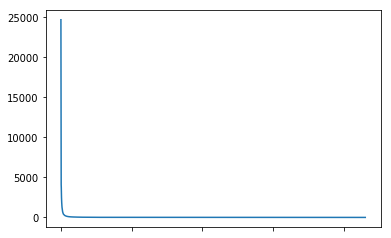

In [14]:
pd.Series(''.join(script['line'].tolist()).split()).value_counts().plot()

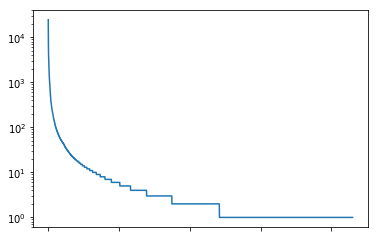

In [15]:
pd.Series(''.join(script['line'].tolist()).split()).value_counts().plot(logy=True)

### Part 2: Talkativity
1. For each of the recurrent characters, calculate their total number of words uttered for all episodes. Based on this, who seems to be the most talkative character?
2. For each of the recurrent characters, calculate their total number of words uttered per episode (ignoring episodes that the character does not appear in), and calculate a robust summary statistic for the word count distribution of each person.

    2.1. What changes do you observe, compared with the previous section?
    
    2.2. Why is this analysis an improvement over the previous one, and how could you improve it even further? _Hint: The improvement involves making your unit for word counts even more granular - you can go further down than episodes._
    
    2.3. Incorporate that improvement. Do you still see the same results? How **confident** can you be that the "most talkative" person given by this twice improved method is really more talkative than the second most talkative one? _Hint: Read the sentence again._

In [16]:
script.groupby('character')['line'].apply(lambda x: len(''.join(x.tolist()).split())).sort_values(ascending=False).to_frame()

,line
character,
Sheldon,185197
Leonard,102323
Penny,79165
Howard,69410
Raj,60044
Amy,39894
Bernadette,27708
Stuart,7946
Mrs Cooper,3381


In [17]:
#median words per episode appeared
script.groupby(['character', 'episode'])['line'].apply(lambda x: len(''.join(x.tolist()).split())).reset_index().groupby('character').median().sort_values(by='line', ascending=False)

,line
character,
Sheldon,7762.5
Leonard,4507.5
Penny,3354.5
Howard,2861.5
Raj,2513.0
Amy,1553.5
Bernadette,1125.5
Mrs Cooper,359.0
Arthur,345.0


In [18]:
#median words per scene appeared
script.groupby(['character', 'episode', 'scene id'])['line'].apply(lambda x: len(''.join(x.tolist()).split())).reset_index().groupby('character').median()[['line']].sort_values(by='line', ascending=False)

,line
character,
Mrs Cooper,103.0
Sheldon,96.0
Arthur,88.0
Beverley,70.0
Leslie,60.0
Kripke,57.0
Penny,55.0
Leonard,52.0
Zack,51.0


### Part 3: Obligatory Spark cameo
Write a Spark script that does the following: Given the raw input file and your list of recurrent characters, create an RDD containing (speaker, dialogue line) rows **only for the recurrent characters**, and then generate a vectorized bag of words representation for each dialogue line, thus generating an RDD with (speaker, bag of words vector) rows. Then, calculate an aggregated bag of words vector (sum of all vectors) for each person. The final output is therefore an RDD with each of its rows being (speaker, aggregated bag of words vector). For your bag of words vectors, you can use $1\times|V|$ scipy CSR matrices (where $|V|$ is the size of the vocabulary). No filtering of the vocabulary is necessary for this part.

You do not need to run this script, but you do need to use Spark logic.

## Task 3: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

1. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points is one **dialogue line**. Now, use the scikit-learn class TfIdfVectorizer to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.
2. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.
3. Now, perform a full singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a 25-dimensional approximation for both the training and test TF-IDF matrices (you can do all of this through the scikit-learn API). Then, train a logistic regression classifier that given a dialogue line, tells you whether it's by Sheldon or by someone else. Perform 10-fold cross-validation. Report the precision, recall and F1-score for both classes, as well as accuracy, of your classifier on the training set and the test set.

    3.1. What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes?

    3.2. Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
    3.3. List 10 of the most extreme false positives and 10 of the most extreme false negatives. What are common features of false positives? What about false negatives?
    
    3.4. What is the most important feature in the model? What are the 5 most important words in this feature, i.e. the highest-weighted words in that column of the $V$ matrix?

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=simple_tokeniser, stop_words=open('helpers/stopwords.txt').read().splitlines())

In [20]:
training_X = script[script['season'].astype(int) < 9]['line']
training_y = script[script['season'].astype(int) < 9]['character'] == 'Sheldon'
test_X = script[script['season'].astype(int) >= 9]['line']
test_y = script[script['season'].astype(int) >= 9]['character'] == 'Sheldon'

In [21]:
training_X = vectorizer.fit_transform(training_X)
test_X = vectorizer.transform(test_X)

(not sure if ANOVA is the appropriate stat test)

In [22]:
from sklearn.feature_selection import f_classif
F, p = f_classif(training_X, training_y)

d = {c:r for c, r in zip(vectorizer.vocabulary_, p)}
pd.DataFrame(sorted(d.items(), key=lambda kv: kv[1])).head()

,0,1
0,flatlines,1.209308e-63
1,aged,8.758101e-53
2,separately,4.348879e-45
3,wood,1.725981e-31
4,cinnamon,2.445385e-30


In [23]:
F, p = f_classif(test_X, test_y)

d = {c:r for c, r in zip(vectorizer.vocabulary_, p)}
pd.DataFrame(sorted(d.items(), key=lambda kv: kv[1])).head()

,0,1
0,hides,0.002020
1,photon,0.059692
2,ask,0.059692
3,plane,0.203576
4,directed,0.454683


In [24]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25)

In [25]:
training_X = svd.fit_transform(training_X)
test_X = svd.transform(test_X)

In [26]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
kf = KFold(n_splits=10)
accuracy=0.0
for train_index, val_index in kf.split(training_X):
    X_train, X_val = training_X[train_index], training_X[val_index]
    y_train, y_val = training_y[train_index], training_y[val_index]
    lr.fit(X_train, y_train)
    accuracy += lr.score(X_val, y_val)
accuracy /= 10
print('validation accuracy:', accuracy)

lr.fit(training_X, training_y)
print('test accuracy:', lr.score(test_X, test_y))

validation accuracy: 0.7534140160098195
test accuracy: 0.7795260104238372


In [27]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_y, lr.predict(test_X)).ravel()
print(tn, fp, fn, tp)
print('precision:', tp/(tp+fp))
print('recall:', tp/(tp+fn))

7888 44 2198 39
precision: 0.46987951807228917
recall: 0.01743406347787215


Sheldon and Leonard are both right (I guess).

## Task 4: The Gossip Graph

**Note: For this task, discard the recurrent characters whose names are not single words.**

In [28]:
rec_characters = [c.lower() for c in rec_characters if len(c.split())==1]
script['character']=script['character'].apply(lambda x: x.lower()) 

### Part 1: The Gossip Graph

Let us define _gossip_ as follows: if a dialogue line of character A mentions B by name in a scene that does not involve character B,, we say that “A gossips about B” in that line. For the sake of simplicity, we only consider mentions where the name of the recurrent character, as it appears in our list of characters, is mentioned; for example, if someone says "Cooper" and they mean Sheldon, we discard that. Create the two following graphs first:

1. Create the _gossip graph_, which is a directed weighted graph, in which there there is a node for each recurrent character, and a directed edge from the node for A to the node for B if A has gossiped about B at least once. The weight of the edge is the number of scenes in which A has gossiped about B.
2. Create the _familiarity graph_, an undirected weighted graph, in which there is a node for each recurrent character, and an edge between two characters if they appear together in at least one scene. The weight of the edge between them is the number of scenes they appear in together. If an edge exists between two people in the familiarity graph, we say that they "know each other".

You can create these two graphs as adjacency matrices first, and then use the packages networkx or igraph.

In [29]:
gossip_graph = script[['line', 'character']].copy()
gossip_graph['mentions'] = gossip_graph['line'].apply(lambda x: list(set([w for w in x.split() if w in rec_characters])))

In [30]:
gossip_graph = gossip_graph['mentions'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('mentions').join(gossip_graph[['character']], how='left')

In [31]:
gossip_graph['weight'] = 1
gossip_graph = gossip_graph.groupby(['character', 'mentions']).sum().reset_index()
gossip_graph.head()

,character,mentions,weight
0,amy,amy,23
1,amy,arthur,2
2,amy,bernadette,52
3,amy,bert,15
4,amy,howard,21


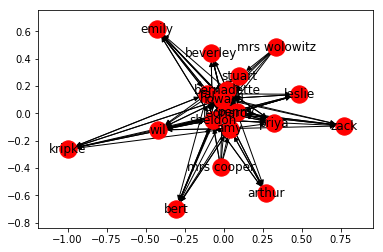

In [32]:
import networkx as nx

GG = nx.DiGraph()
gossip_graph.apply(lambda x: GG.add_edge(x['character'], x['mentions'], weight=x['weight']), axis=1)
nx.draw_networkx(GG)

In [33]:
familiarity_graph = script[['scene id', 'character']].copy()
familiarity_graph = familiarity_graph.merge(familiarity_graph, on='scene id')
familiarity_graph = familiarity_graph.drop_duplicates() 

In [34]:
#alphabetical order of characters
familiarity_graph = pd.DataFrame(familiarity_graph.apply(lambda x: {'scene id':x['scene id'], 'character_x':x['character_x'] , 'character_y':x['character_y']} if x['character_x']<x['character_y'] else {'scene id':x['scene id'], 'character_x':x['character_y'] , 'character_y':x['character_x']}, axis=1).tolist())
familiarity_graph = familiarity_graph.drop_duplicates() 

In [35]:
familiarity_graph = familiarity_graph[familiarity_graph['character_x'] != familiarity_graph['character_y']]

In [36]:
familiarity_graph['weight'] = 1
familiarity_graph = familiarity_graph[['character_x', 'character_y', 'weight']].groupby(['character_x', 'character_y']).sum().reset_index()
familiarity_graph.head()

,character_x,character_y,weight
0,amy,arthur,1
1,amy,bernadette,252
2,amy,bert,18
3,amy,beverley,4
4,amy,emily,7


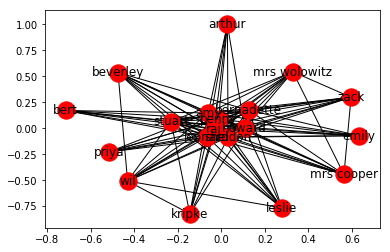

In [37]:
FG = nx.Graph()
familiarity_graph.apply(lambda x: FG.add_edge(x['character_x'], x['character_y'], weight=x['weight']), axis=1)
nx.draw_networkx(FG)

Now, answer the following questions:

1. Sheldon claims that every character in the show is familiar with everyone else through at most one intermediary. Based on the familiarity graph, is this true? If not, at most how many intermediaries are needed?
2. Who is the character through whom the largest number of these indirect familiarities happen? Calculate an appropriate centrality metric on the familiarity graph to answer this question. You can use the package networkx for this section.
3. Another claim of Sheldon's (we know, there are already way too many of them) is that every recurrent character in the show gossips about all the other recurrent characters. What property of the gossip graph would correspond to this? Does the gossip graph possess that property? If not, then is it the case that for every pair of recurrent characters, at least one gossips about the other? What property would this correspond to?
4. Use the gossip graph and the familiarity graph to figure out if for every pair of recurrent characters, one of them has gossiped about the other if and only if they know each other. Explain your method - the simpler, the better.

In [38]:
#1
print(max([v for _ , c in nx.all_pairs_shortest_path_length(FG) for v in c.values()]), 'intermediaries')

2 intermediaries


In [39]:
#2
max(nx.betweenness_centrality(FG).items(), key=lambda k: k[1])

('amy', 0.04956427015250544)

In [40]:
#3
min(dict(GG.out_degree).items(), key=lambda k: k[1])[1] == len(rec_characters)

False

### Part 2: The Gossiplord

Sheldon and Leonard are having a disagreement about how "gossipyness" should be defined. Leonard insists that they keep it simple, and to calculate a Gossip% for each person, which for person P is defined as:
$$ \frac{| \: Number \: of \: scenes \: in \: which \: P \: is \: gossiping \: |}{| \: Number \: of \: scenes \: in \: which \: P \: appears \: |} $$

On the other hand, Sheldon thinks that the better idea is to normalize each person's gossiping about each other person by how well-acquainted they are. His proposition is the NormGossip, which for person P is calculated as follows:
$$ \sum_{X \in Recurrent \: and \: X \neq P} \frac{| \: Scenes \: where \: P \: gossips \: about \: X \: |}{| \: Scenes \: where \: P \: appears \: together \: with \: X \: |} $$


1. Calculate the Gossip% for all recurrent characters. Who are the top 3 gossipers?
2. Calculate the NormGossip for all recurrent characters. According to this measure, who are the top 3 gossipers?
3. What are the pros and cons of each measure? In what situations would each of them perform badly? Which one would you consider to be a superior score? How could you improve Sheldon's NormGossip, using ideas from TF-IDF weighting?